<a href="https://colab.research.google.com/github/human1abs/portfolio/blob/main/CNN-skin-cancer-detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import transformers as hft
import tensorflow as tf
import mlflow
import pickle
from nose.tools import *

import io
import requests
from PIL import Image

import tensorflow_hub as hub

from collections import Counter

import skimage.io
from skimage.io import imread

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Flatten, Input, Dropout, Conv2D, MaxPool2D, GlobalAveragePooling2D

from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l2

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

from sklearn.neighbors import KNeighborsTransformer
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import tree
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix,  ConfusionMatrixDisplay, classification_report
from sklearn.utils import class_weight

from xgboost import XGBClassifier

2023-12-01 07:56:32.569019: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Introduction

This paper aims at searching for reliable ways to signal for malignant skin developments of the melanoma type by the means of Machine Learning and Deep Neural Networks methodologies, utilising the knowledge gained during SoftUni's Machine Learning course. I will use the following free [dataset](https://www.kaggle.com/datasets/cdeotte/jpeg-isic2019-512x512) published in Kaggle.

The dataset contains images with a total size of around 1.5GB. If for some reason it's not convenient to download them from Kaggle, here's a link to them stored in my personal [Google Drive](https://drive.google.com/drive/folders/1BG8zbxiZD8s2EowK3I4YQFdVciQGy_c7?usp=share_link). Here, you will also find saved versions of the final two models presented in this paper (complete with their training history) - as there was not enough space for all the models to be uploaded along with the paper.

And now, back to the main topic:

The possibility to determine malignant melanoma with a reliable degree of probability, based only on a photo complete with basic personal data, presents people with the amazing opportunity to get medical diagnosis while the cancer development is still at its early stages - which are related to significantly higher survival rates.

According to the [World Cancer Research Fund](https://www.wcrf.org), almost 325,000 people were diagnosed with malignant melanoma in 2020, which makes the deadly disease the 17th most common cancer worldwide (and 13th for men).

The lives of thousands could be saved if they had a seamless way to check what the odds are for their skin developments to be cancerogenic. So let's go ahead and see if we can find a way to improve melanoma diagnostics based on the data.

# About the Data and its Authors
The data was created by the [Society for Imaging Informatics in Medicine (SIIM)](https://siim.org) and [International Skin Imaging Collaboration (ISIC)](https://www.isic-archive.com). SIIM is the leading healthcare organization for informatics in medical imaging whose mission is to advance medical imaging informatics through education, research, and innovation in a multi-disciplinary community. ISIC is an international effort to improve melanoma diagnosis. The ISIC Archive contains the largest publicly available collection of quality-controlled dermoscopic images of skin lesions.

# Assumptions and Metrics

This paper will try to find an optimal model for two-class (binary) classification. However, this dataset is very much imbalanced and we have to pick our metrics more carefuly. Luckily, the non-cancerogenic skin developments are prevailing by a lot. Let's take a look:

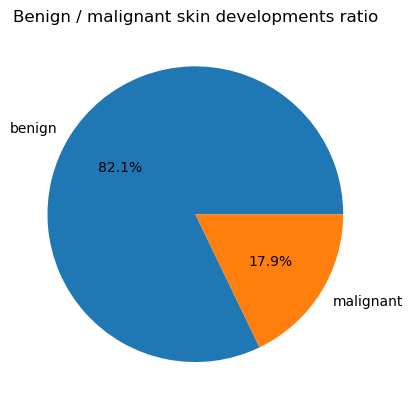

In [ ]:
skin_cancer = pd.read_csv("dataset/train.csv")
labels = skin_cancer.benign_malignant.value_counts().index.values
sizes = skin_cancer.benign_malignant.value_counts().values
fig, ax = plt.subplots()
plt.title('Benign / malignant skin developments ratio')
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show()

This imbalance poses an additional challenge for our reserarch when it comes to selecting the right metrics. If we pick just **Accuracy** - the most common criteria - it would be possible to get 82% accuracy and still be wrong about all malignant cases, and even if we reached 90% accuracy, it would still be possible to missclassify most of the cancer patients! Of course, we don't want that. Obviously, **Accuracy** is not enough and we need another metric (or a combo of metrics).
## Main metric: Recall
What are we actually measuring here? Let's try too see the situation from the perspective of skin patients:
People who feel at risk of melanoma would like to find out asap whether *they have it* or *they don't have it*. This implies the following 4 scenarios:

* *they have it*:
    1. the model correctly indicates that they do;
    2. the model incorrectly indicates that they don't;
    
* *they don't have it*:
    3. the model correctly indicates they don't;
    4. the model incorrectly indicates that they do;

If one mistakenly gets diagnosed of cancer, that would probably mean the death of many nerves, but his/her life in general won't be under immediate threath.

So let's assume that **the case of having a deadly skin disease is more urgent** than the case of not having it, shall we? The metric that measures optimum of the first two of the above cases is **Recall**. More specifically, we will focus on optimising for the **Recall** on the **malignant** cases. They will be also referred to as "positive cases" or as the 1s.

## It's all about the balance

Unfortunately, optimising only for this metric won't be enough. It's easy to bring **Recall** for malignant cases to 100% by missclassifying all the others. To make sure our models won't "cheat" in this or any other similar ways, we will be looking at other relevant metrics such as:
* **Precision;**
* **F1-score**.

## Target
Of course, it's unrealistic to expect that a beginner in the field of machine learning such as the author of this paper would manage to build a perfect model for diagnosing skin cancer. Nevertheless, some standards based on which the performance of our models will be judged need to be set. Lets set an individual target for each of the metrics mentioned above:
### Main metric (Recall): 70% and above**
### Additional metric (Precision): 55% and above**

There is no need to set a separate target for the **F1-score** as it is a relation between **Precision** and **Recall** A model able to identify 70% of the true melanoma cases correctly, while performing at least above the average on the other relevant metrics, will be a credible enough starting point for deciding what the next step would be.

Last but not least:

*These targets apply only for the model's performance on the malignant cases (aka the positives or the 1s).*

# 1. Feature Engineering and Preparations
## Tabular data.

We've got a pretty orderly set of tabular data, complete with 25331 photos of skin developments of real patients. Each image matches a value in the "image_name" column. As we can see, the classification categories are not very balanced - less than 18% malignant cases vs more than 82% benign cases.

In [ ]:
skin_cancer.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_0000000,-1,female,55.0,anterior torso,NV,benign,0,4,1022,767
1,ISIC_0000001,-1,female,30.0,anterior torso,NV,benign,0,18,1022,767
2,ISIC_0000002,-1,female,60.0,upper extremity,MEL,malignant,1,0,1022,767
3,ISIC_0000003,-1,male,30.0,upper extremity,NV,benign,0,24,1022,767
4,ISIC_0000004,-1,male,80.0,posterior torso,MEL,malignant,1,14,1022,767


In [ ]:
skin_cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     25331 non-null  object 
 1   patient_id                     25331 non-null  int64  
 2   sex                            25331 non-null  object 
 3   age_approx                     24894 non-null  float64
 4   anatom_site_general_challenge  22700 non-null  object 
 5   diagnosis                      25331 non-null  object 
 6   benign_malignant               25331 non-null  object 
 7   target                         25331 non-null  int64  
 8   tfrecord                       25331 non-null  int64  
 9   width                          25331 non-null  int64  
 10  height                         25331 non-null  int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 2.1+ MB


We've got a pretty orderly set of tabular data, complete with 25331 photos of skin developments of real patients. Each image matches a value in the "image_name" column. As we can clearly see, the classification categories are not very balanced:

Undoubtedly, the photos contain much more critical information than the tabular metadata. Before we get to the photos, however, let's see what we can do with this data - maybe, later on, it could be combined with the image data to improve the overall output of the upcoming observations.

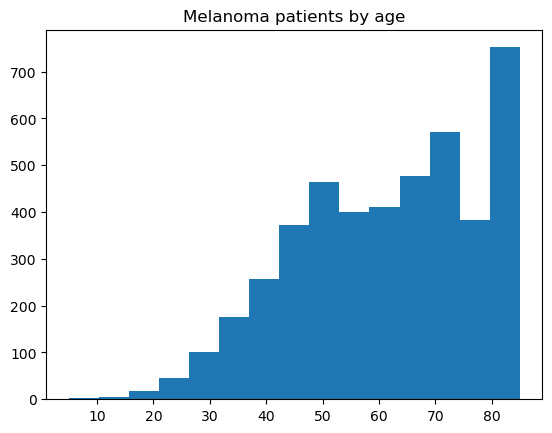

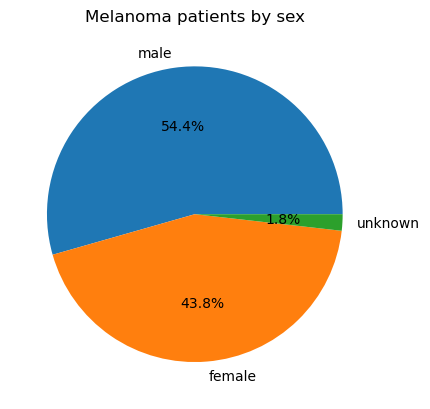

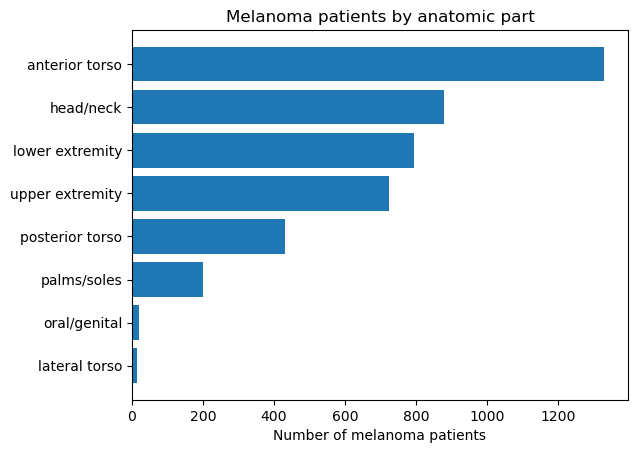

In [ ]:
ds_malignant = skin_cancer[skin_cancer.target == 1]

plt.title('Melanoma patients by age')
plt.hist(ds_malignant.age_approx, bins=15)
plt.show()

labels_sex = " ".join(ds_malignant.sex.value_counts().index.values).split(' ')
sizes_sex = ds_malignant.sex.value_counts().values
plt.title('Melanoma patients by sex')
plt.pie(sizes_sex, labels=labels_sex, autopct='%1.1f%%')
plt.show()


labels_anat = ds_malignant.anatom_site_general_challenge.value_counts().index.values[::-1]
sizes_anat = ds_malignant.anatom_site_general_challenge.value_counts().values[::-1]
plt.title('Melanoma patients by anatomic part')
plt.xlabel('Number of melanoma patients')
plt.barh(labels_anat, sizes_anat)
plt.show()

In [ ]:
target = skin_cancer["target"]
features = skin_cancer.drop(columns = ["image_name", "patient_id", "diagnosis",
                                       "benign_malignant", "target", "tfrecord", "width", "height"])
features.anatom_site_general_challenge = features.anatom_site_general_challenge.fillna('unknown')
features = features.rename(columns={"anatom_site_general_challenge": "anatomy", "age_approx": "age"})
features_for_modelling = pd.get_dummies(features)
features_for_modelling.head()

,age,sex_female,sex_male,sex_unknown,anatomy_anterior torso,anatomy_head/neck,anatomy_lateral torso,anatomy_lower extremity,anatomy_oral/genital,anatomy_palms/soles,anatomy_posterior torso,anatomy_unknown,anatomy_upper extremity
0,55.0,True,False,False,True,False,False,False,False,False,False,False,False
1,30.0,True,False,False,True,False,False,False,False,False,False,False,False
2,60.0,True,False,False,False,False,False,False,False,False,False,False,True
3,30.0,False,True,False,False,False,False,False,False,False,False,False,True
4,80.0,False,True,False,False,False,False,False,False,False,True,False,False


As the data is being prepared for modelling, let's drop the columns "diagnosis" and "bening_malignant" because the former is highly colinear with the "target" column and the latter literally presents the information of the "target" column in categorical terms. The rest of the removed columns are not relevant.

### Group Ages into Age Groups
Hmm... as it became clear from the age-related pie chart above, malignant skin disease is rather unevenly distributed amongst ages. Melanoma diagnoses soar for patients above 40.

In [ ]:
age_group = pd.cut(features_for_modelling['age'], bins=[0, 14, 28, 42, 56, 70, 85],
                  labels=['0 to 14', '15 to 28', '29 to 42', '43 to 56', '57 to 70', '71 to 85'])
skin_cancer['age_group'] = age_group

print(skin_cancer[skin_cancer.target == 1].age_group.value_counts())

age_group
57 to 70    1458
43 to 56    1238
71 to 85    1135
29 to 42     536
15 to 28      68
0 to 14        2
Name: count, dtype: int64


Divide and conquer - specific patient ages are important, but upon dividing them into age groups we have much more useful information about the trends, while this also allows for ages to be present in the tabular dataset at a similar level with the anatomic categories.

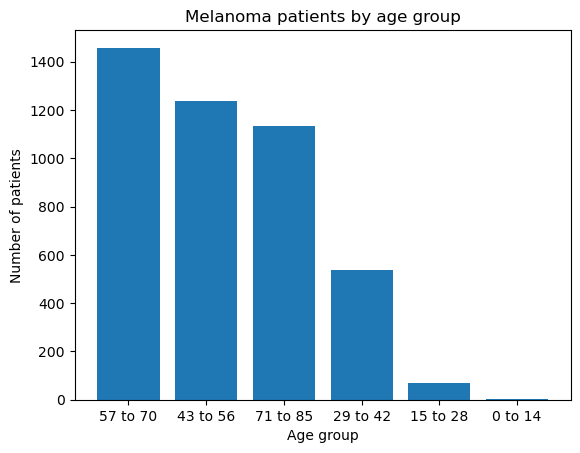

In [ ]:
labels = skin_cancer[skin_cancer.target == 1].age_group.value_counts().index.values
sizes = skin_cancer[skin_cancer.target == 1].age_group.value_counts().values
plt.bar(labels, sizes)
plt.title('Melanoma patients by age group')
plt.ylabel('Number of patients')
plt.xlabel('Age group')
plt.show()

Let's replace the unknown values with the most "best-presented" age group (pun intended) among the skin cancer patients:

In [ ]:
skin_cancer['age_group'] = skin_cancer['age_group'].fillna(age_group.value_counts().index.values[0])

### Replacing ages with age groups, one-hot encoding, turning booleans into integers...

In [ ]:
features_for_modelling.insert(0, 'age_group', skin_cancer['age_group'])
features_for_modelling = features_for_modelling.drop(columns=['age'])
features_for_modelling = pd.get_dummies(features_for_modelling)
features_for_modelling = features_for_modelling.astype(int)
features_for_modelling.head()

,sex_female,sex_male,sex_unknown,anatomy_anterior torso,anatomy_head/neck,anatomy_lateral torso,anatomy_lower extremity,anatomy_oral/genital,anatomy_palms/soles,anatomy_posterior torso,anatomy_unknown,anatomy_upper extremity,age_group_0 to 14,age_group_15 to 28,age_group_29 to 42,age_group_43 to 56,age_group_57 to 70,age_group_71 to 85
0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [ ]:
features_for_modelling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   sex_female               25331 non-null  int64
 1   sex_male                 25331 non-null  int64
 2   sex_unknown              25331 non-null  int64
 3   anatomy_anterior torso   25331 non-null  int64
 4   anatomy_head/neck        25331 non-null  int64
 5   anatomy_lateral torso    25331 non-null  int64
 6   anatomy_lower extremity  25331 non-null  int64
 7   anatomy_oral/genital     25331 non-null  int64
 8   anatomy_palms/soles      25331 non-null  int64
 9   anatomy_posterior torso  25331 non-null  int64
 10  anatomy_unknown          25331 non-null  int64
 11  anatomy_upper extremity  25331 non-null  int64
 12  age_group_0 to 14        25331 non-null  int64
 13  age_group_15 to 28       25331 non-null  int64
 14  age_group_29 to 42       25331 non-null  int64
 15  ag

In [ ]:
features_train_tabular, features_test_tabular, target_train_tabular, target_test_tabular = train_test_split(
    features_for_modelling, target, train_size = 0.8, test_size = 0.2, random_state=42)

In [ ]:
assert_equal(features_train_tabular.shape, (20264, 18))
assert_equal(features_test_tabular.shape, (5067, 18))
assert_equal(target_train_tabular.shape, (20264,))
assert_equal(target_test_tabular.shape, (5067,))

## Images

The feature engineering of the images will go as follows:
1. Get the images as np.arrays:
    * Load them from the database;
    * Decode them;
    * Normalize them;
    * Put them all into a (quite big) numpy array.
2. Flatten the images;
3. Perform Principal Component Analysis on them.

The images will be used in all the formats mentioned above, so it's crucial to prepare them in the right manner.

### Get all the images into a numpy array

In [ ]:
def get_image(image_path):
    image = tf.io.read_file(image_path)
    image_decoded = tf.image.decode_jpeg(image, channels=3)
    image_resized = tf.image.resize(image_decoded, [128, 128])
    image_normalized = image_resized / 255.0
    return image_normalized

skin_images = []
for i in range(len(skin_cancer.image_name)):
    image_path = "dataset/train/" + skin_cancer.image_name[i] + ".jpg"
    skin_images.append(get_image(image_path))
skin_images = np.array(skin_images)

Here is the most convenient moment to divide them into train and test sets using train_test_split:

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(
    skin_images, target, train_size = 0.80, test_size = 0.20, random_state=42)

In [ ]:
assert_equal(len(skin_images), 25331)

### Flatten the images

In [ ]:
skin_images_flat = []
for image in skin_images:
    image = image.flatten()
    skin_images_flat.append(image)

Now is the right moment to divide them via train_test_split for further enquiries, as there is a PCA coming up.

In [ ]:
features_flat_train, features_flat_test, target_flat_train, target_flat_test = train_test_split(
    skin_images_flat, target, train_size = 0.80, test_size = 0.20, random_state=42)

### Perform PCA on the flat features

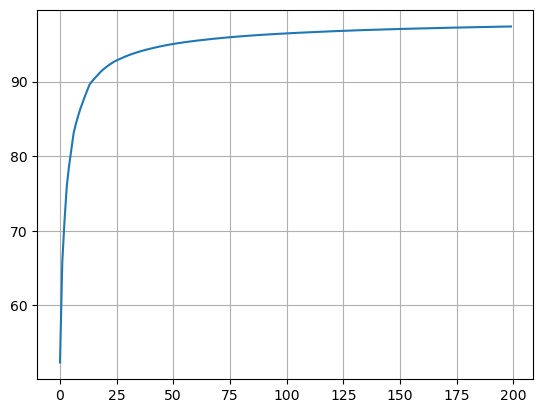

In [ ]:
features_flat_train_pca_200 = PCA(n_components=200)
features_flat_train_pca_200.fit(features_flat_train)

plt.grid()
plt.plot(np.cumsum(features_flat_train_pca_200.explained_variance_ratio_ * 100))
plt.show()

In [ ]:
np.cumsum(features_flat_train_pca_200.explained_variance_ratio_[:50])

array([0.52352405, 0.65822496, 0.71439658, 0.76030009, 0.78716552,
       0.80938627, 0.83089426, 0.84332179, 0.8540362 , 0.86379181,
       0.87227556, 0.88039872, 0.88822299, 0.89575362, 0.89997752,
       0.90341562, 0.90675888, 0.9100959 , 0.91327279, 0.9161089 ,
       0.91861631, 0.92095866, 0.92310478, 0.9250651 , 0.9269668 ,
       0.92845315, 0.92986414, 0.93123895, 0.93258136, 0.93383668,
       0.93504589, 0.93621704, 0.93727678, 0.93829355, 0.93927217,
       0.9402355 , 0.94112137, 0.94195788, 0.94275921, 0.94352282,
       0.9442745 , 0.94501078, 0.94573445, 0.94642143, 0.94707063,
       0.94769913, 0.9482885 , 0.94887552, 0.94943517, 0.94997272])

Roughly 95% of the information from over 49,000 dimensions compressed into only 50 dimensions? Hell yeah.

In [ ]:
features_flat_pca_50 = PCA(n_components=50)
features_flat_pca_50.fit(features_flat_train)
features_flat_train_pca_50 = features_flat_pca_50.transform(features_flat_train)
features_flat_test_pca_50 = features_flat_pca_50.transform(features_flat_test)

## Useful Functions
For practical reasons, let's put the most used functions into one place.

### Get the Confusion Matrix and the Classification Report on a model:

In [ ]:
def get_cm_cr(model, features_test, target_test):
    prediction = model.predict(features_test)
    predictions = [1 if i>=0.5 else 0 for i in prediction]
    cr = classification_report(target_test, predictions)
    cm = confusion_matrix(target_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['benign', 'malignant'])
    disp.plot()
    plt.show()
    print(cr)

### Save & load model history (or other objects) via Pickle:

In [ ]:
def save_model_history(fp_model_history, model_history):
    with open(fp_model_history, 'wb') as file:
        pickle.dump(model_history.history, file)

def load_model_history(fp_model_history):
    with open(fp_model_history, 'rb') as file:
        loaded_model = pickle.load(file)
        return loaded_model

### Plot model history

In [ ]:
def plot_model_history(model_history, metric_str):
    plt.plot(model_history[metric_str])
    plt.plot(model_history['val_'+metric_str])
    plt.title('model '+metric_str)
    plt.ylabel(metric_str)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### Plot cross-validation scores

In [ ]:
def plot_cv_scores_combined(scores):
    f, ax = plt.subplots(1)
    ax.set_ylim(ymin=0)
    ax.plot(scores['test_recall'])
    ax.plot(scores['test_precision'])
    ax.plot(scores['test_f1_macro'])
    plt.title('Cross-validation on the RandomizedSearchCV best estimator')
    plt.legend(['test recall', 'test precision', 'test f1-macro'])
    plt.show()

# 2. Support Vector Machines


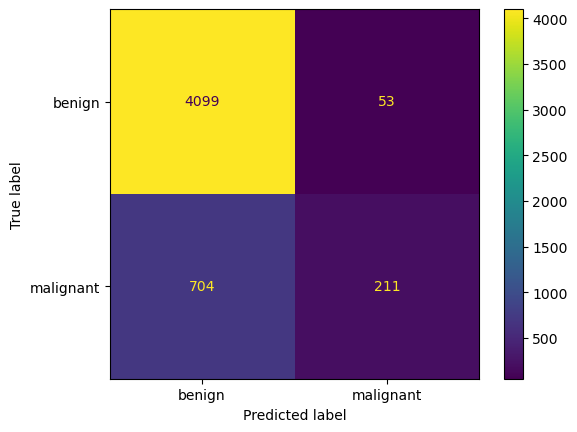

              precision    recall  f1-score   support

           0       0.85      0.99      0.92      4152
           1       0.80      0.23      0.36       915

    accuracy                           0.85      5067
   macro avg       0.83      0.61      0.64      5067
weighted avg       0.84      0.85      0.81      5067



In [ ]:
svc = SVC(kernel='rbf', gamma=0.002, random_state=42)
svc.fit(features_flat_train_pca_50, target_flat_train)
get_cm_cr(svc, features_flat_test_pca_50, target_flat_test)

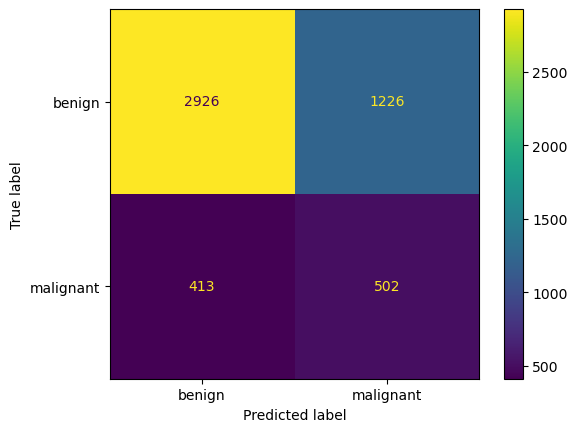

              precision    recall  f1-score   support

           0       0.88      0.70      0.78      4152
           1       0.29      0.55      0.38       915

    accuracy                           0.68      5067
   macro avg       0.58      0.63      0.58      5067
weighted avg       0.77      0.68      0.71      5067



In [ ]:
svc_balanced_rbf = SVC(C=0.001, class_weight='balanced', random_state=42)
svc_balanced_rbf.fit(features_flat_train_pca_50, target_flat_train)
get_cm_cr(svc_balanced_rbf, features_flat_test_pca_50, target_flat_test)

Obviously, Recall on the malignant cases has improved by more than 3 times. Unfortunately this came at the expense of losing on the corresponding Precision, although it didn't go as deep as Recall on one was at the previous model. There is a better tradeoff, between precision and recall than before, as shown by the improved f-1 score. Not the best result possible, but we will take it. On to the next SVM model!

### Randomized Search
I will use the Randomized Search in order to find the best version of our model. Why pick RandomizedSearchCV over GridSearchCV? Simple - GridSearch finds it too hard to work on that data, even on the PCA-ed version.
Tuning the "class-weight" parameter to 'balanced' seems to have worked pretty well on the **Recall**, so I'm gonna stick to it.

This time, the scoring metric is set to 'roc_auc' as this turned out to get the best results. Oddly enough, when optimizing for 'recall' or 'f1_macro', I keep getting terrible results for the cancer-positive case (and by terrible, I mean zero recall on the '1's...) Maybe the reason why that happens is that this model optimizes for the best overall Recalls and F1-Scores, not necessarily for the ones on the malignan cases.

Therefore ROC Area Under the Curve is the only relevant metric that works.

In [ ]:
svm_optimal = SVC(class_weight='balanced')
param_grid = {'C': [0.01, 0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
svm_rs_model = RandomizedSearchCV(svm_optimal, param_distributions=param_grid, n_iter=4,
                        scoring='roc_auc', n_jobs=-1, cv=4, verbose=1, random_state=42)
svm_rs_model.fit(features_flat_train_pca_50, target_flat_train)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


RandomizedSearchCV(cv=4, estimator=SVC(class_weight='balanced'), n_iter=4,
                   n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10, 100],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['rbf']},
                   random_state=42, scoring='roc_auc', verbose=1)

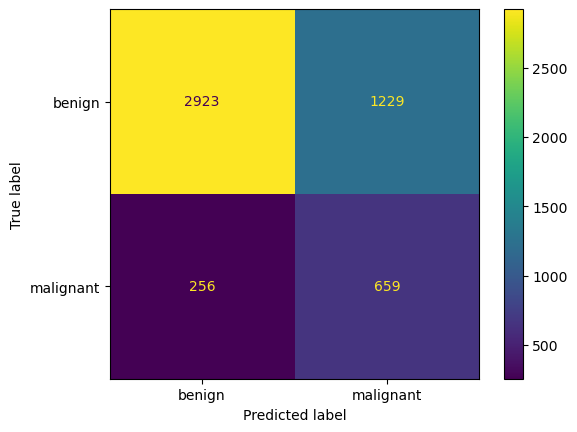

              precision    recall  f1-score   support

           0       0.92      0.70      0.80      4152
           1       0.35      0.72      0.47       915

    accuracy                           0.71      5067
   macro avg       0.63      0.71      0.63      5067
weighted avg       0.82      0.71      0.74      5067



In [ ]:
get_cm_cr(svm_rs_model, features_flat_test_pca_50, target_flat_test)

This one has worked out better, but still not good enough. **Precision** on the 1s is still quite low, even now. However, **Recall** on the 1s is almost in the good zone (above 70%). Maybe we are on the right path.

### Cross-validation metrics on the RandomizedSearchCV (RS) best estimator

Let's do some cross-validation scores on the RS's best estimator and see how our key metrics would do.

In [ ]:
svm_rs_model.best_estimator_

SVC(C=0.1, class_weight='balanced', gamma=0.001)

In [ ]:
svm_rs_model_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
scores_combined_svm = cross_validate(svm_rs_model.best_estimator_, features_flat_train_pca_50,
                        target_flat_train, scoring=('recall', 'f1_macro', 'precision'), cv=svm_rs_model_cv,
                        n_jobs=-1, return_train_score=True)

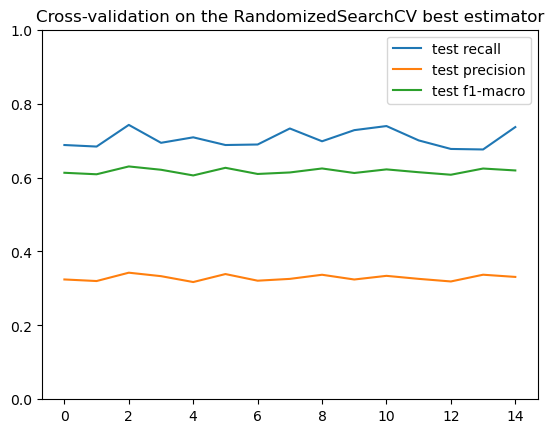

In [ ]:
plot_cv_scores_combined(scores_combined_svm)

Things keep getting better and better for our metrics. The mean revolving around 70%. We should keep in mind that these metrics are merged - for the 0s and for the 1s combined. These results show a certain level of stability compared with the RS' best estimator.

It almost looks like we ran out of options. There is one more thing, though, that we can do - albeit quite unusual:

### SVM Model as a Convolutional Neural Network using Transfer Learning

It is possible actually to create a Support Vector Machine classificator by tweaking some of the hyperparameters of a typical Tensorflow Convolutional Neural Network (CNN):
* set kernel_regularizer to l2(0.01) in the output layer;
* set activation to 'linear';
* set loss to 'hinge'.

That, however, was not enough for sufficient results. Therefore, I applied Transfer Learning, by borrowing one of the best performing feature vectors from MobileNet, trained on the famous ImageNet dataset:

In [ ]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_128/feature_vector/5"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=(128, 128, 3))
feature_extractor_layer.trainable = False

The next step is to try and get the weights of classes less unbalanced - we will use the scikit-learn understanding of balancing the weights: **n_samples / (n_classes * np.bincount(y)).**

In [ ]:
balanced_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                        classes= np.unique(target_train), y= target_train)
balanced_weights = dict(enumerate(balanced_weights))
print(balanced_weights)

{0: 0.6082727982229693, 1: 2.808982533961741}


In [ ]:
tl_svm = Sequential([
    feature_extractor_layer,
    Dense(64, activation= 'relu', name="image_dense"),
    Dropout(0.4),
    Dense(1,kernel_regularizer=l2(0.01),activation = "linear")
    ])
tl_svm.compile(optimizer = 'adam', loss = "hinge", metrics = ['accuracy', 'Recall'])

In [ ]:
#tl_svm_history = tl_svm.fit(features_train, target_train, validation_data=(features_test, target_test),
#                     batch_size=128, class_weight=balanced_weights, epochs=15)

In [ ]:
tl_svm = load_model('tl_svm')

159/159 [==============================] - 42s 260ms/step


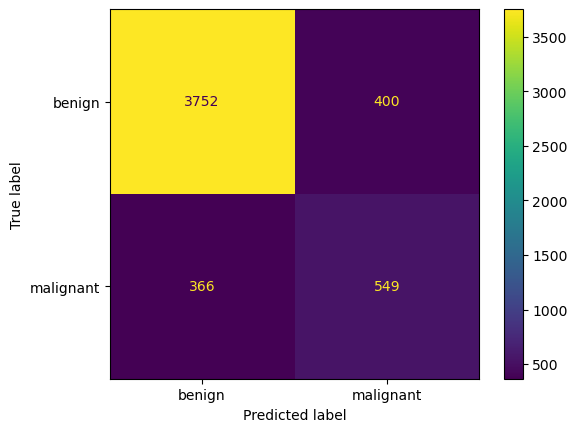

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      4152
           1       0.58      0.60      0.59       915

    accuracy                           0.85      5067
   macro avg       0.74      0.75      0.75      5067
weighted avg       0.85      0.85      0.85      5067



In [ ]:
get_cm_cr(tl_svm, features_test, target_test)

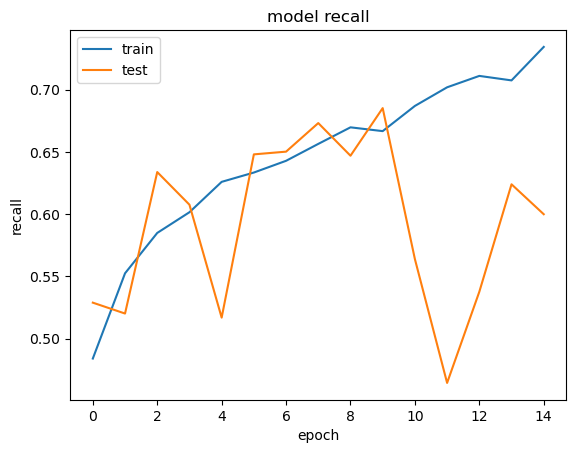

In [ ]:
tl_svm_history = load_model_history('tl_svm_history.pickle')
plot_model_history(tl_svm_history, 'recall')

Interesting! Here we look at the most balanced results in terms ratio between **Precision** and **Recall** so far. Often, when one of them performs well, the other one performs poorly. It shows that our model is just as unlikely to misdiagnose a cancer patient as it is to scare healthy one with a cancer diagnose.

Although things seem to be very random, being able to recognize more than 50% of the positive cases when their share in the total number is only less than 18% is not too bad of a result.

# 3. Trees and Ensembles

We tried with SVMs, let's take a good look at how the tree-based models might help us diagnose melanoma. First, we will start with a basic decision

### Decision Trees

The most curious thing about the decision tree model was that it provides better results when the **class_weight** parameter was set in the opposite direction compared to SVMs. By allocating more weight to the prevailing class, the model actually get better (well, actually - less bad). Take a look:

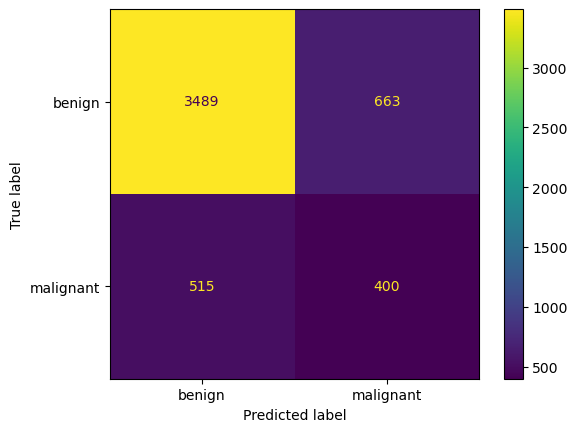

              precision    recall  f1-score   support

           0       0.87      0.84      0.86      4152
           1       0.38      0.44      0.40       915

    accuracy                           0.77      5067
   macro avg       0.62      0.64      0.63      5067
weighted avg       0.78      0.77      0.77      5067



In [ ]:
tree_one = DecisionTreeClassifier(criterion='gini', class_weight={0:9, 1:1}, random_state=42)
tree_one.fit(features_flat_train_pca_50, target_flat_train)
get_cm_cr(tree_one, features_flat_test_pca_50, target_flat_test)

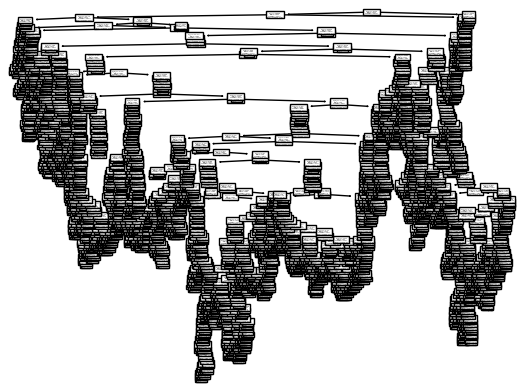

In [ ]:
tree.plot_tree(tree_one)
plt.show()

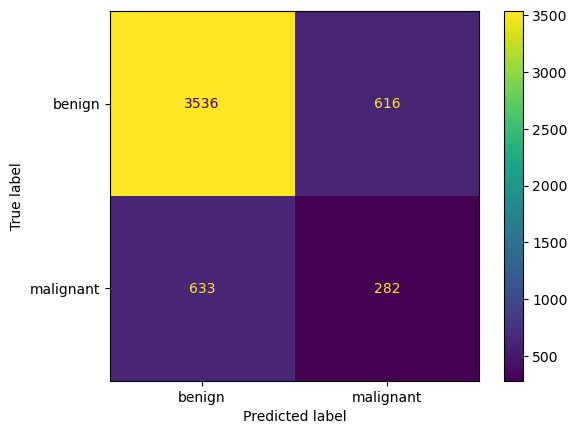

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4152
           1       0.31      0.31      0.31       915

    accuracy                           0.75      5067
   macro avg       0.58      0.58      0.58      5067
weighted avg       0.75      0.75      0.75      5067



In [ ]:
tree_two = DecisionTreeClassifier(criterion='gini', class_weight='balanced', random_state=42)
tree_two.fit(features_flat_train_pca_50, target_flat_train)
get_cm_cr(tree_two, features_flat_test_pca_50, target_flat_test)

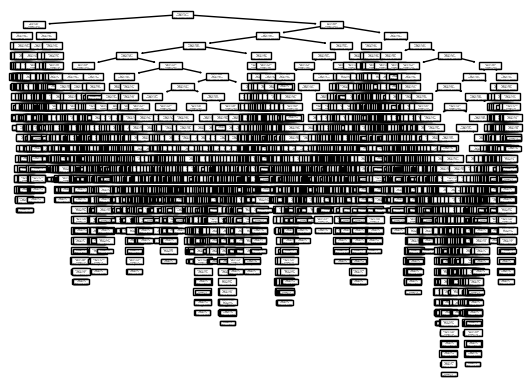

In [ ]:
tree.plot_tree(tree_two)
plt.show()

### XGBoost Models
After this interesting start, we will pay more attention to XGBoost. It got my attention because I've read in several places - such as the research article ["The Image Classification Method with CNN-XGBoost Model Based on Adaptive Particle Swarm Optimization"](https://www.researchgate.net/publication/350779605_The_Image_Classification_Method_with_CNN-XGBoost_Model_Based_on_Adaptive_Particle_Swarm_Optimization) - that XGBoost models are not only very good with tabular data, but also some of the most popular machine learning models for image classification among the non-CNN image classifiers. In fact, they go well together.

In [ ]:
xg_boost = XGBClassifier(base_score=0.18, class_weight=balanced_weights)
xg_boost.fit(features_flat_train_pca_50, target_flat_train)

/opt/anaconda3/envs/hftransformers/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:09:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=0.18, booster=None, callbacks=None,
              class_weight={0: 0.6082727982229693, 1: 2.808982533961741},
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

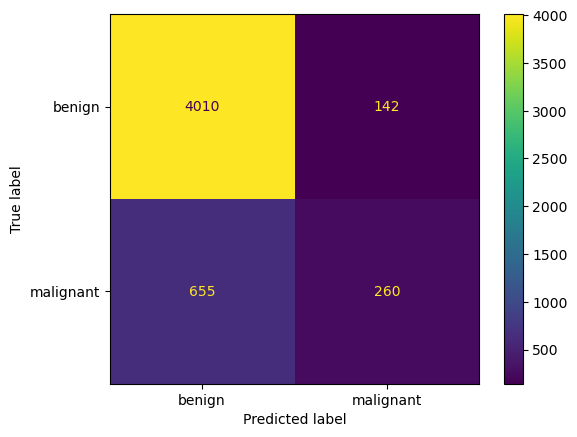

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      4152
           1       0.65      0.28      0.39       915

    accuracy                           0.84      5067
   macro avg       0.75      0.62      0.65      5067
weighted avg       0.82      0.84      0.82      5067



In [ ]:
get_cm_cr(xg_boost, features_flat_test_pca_50, target_flat_test)

Unfortunately, for some reason the *'class_weight'* hyperparameter doesn't work. According to my research it is supposed to be very effective, but this time, it just doesn't work and that's not the only model. Still, it's better than nothing. Let's try the RandomizedSearchCV - maybe it could help us get better results.

In [ ]:
params = {
 "learning_rate" : [ 0.04, 0.06, 0.08, 0.10, 0.12 ],
 "max_depth" : [ 17, 19, 21, 23, 25 ],
 "min_child_weight" : [ 3, 5, 7, 9, 11 ],
 "gamma" : [ 0.2, 0.3, 0.4, 0.5, 0.6 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5, 0.6, 0.7 ]
}

In [ ]:
xg_boost_images_upgrade = XGBClassifier(base_score=0.18)
rs_model = RandomizedSearchCV(xg_boost_images_upgrade, param_distributions=params, n_iter=5,
                              scoring='recall', n_jobs=-1, cv=5, verbose=3, random_state=42)
rs_model_history = rs_model.fit(features_flat_train_pca_50, target_flat_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


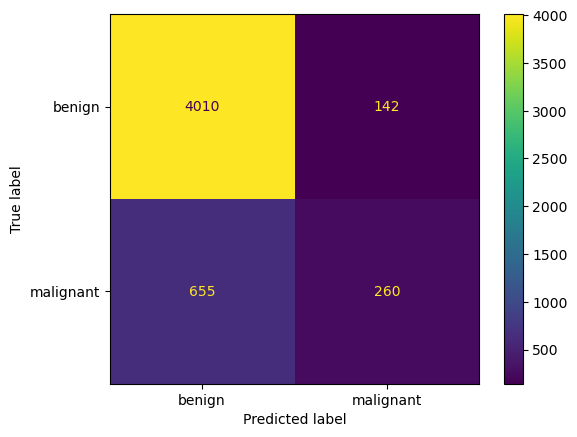

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      4152
           1       0.65      0.28      0.39       915

    accuracy                           0.84      5067
   macro avg       0.75      0.62      0.65      5067
weighted avg       0.82      0.84      0.82      5067



In [ ]:
get_cm_cr(xg_boost, features_flat_test_pca_50, target_flat_test)

In [ ]:
rs_model.best_estimator_

XGBClassifier(base_score=0.18, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.6, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=17, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
rs_model_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
scores_combined_xgboost = cross_validate(rs_model.best_estimator_, features_flat_train_pca_50,
                        target_flat_train, scoring=('recall', 'f1_macro', 'precision'), cv=rs_model_cv,
                        n_jobs=-1, return_train_score=True)

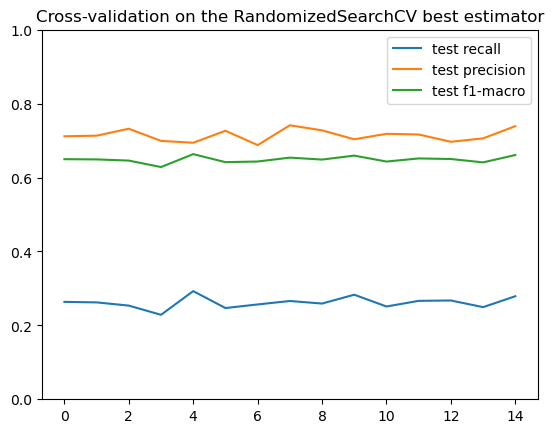

In [ ]:
plot_cv_scores_combined(scores_combined_xgboost)

It's really starting to look like there these tree-based methods cannot provide the balance that our model needs for good result on the **Recall** on the positives.

### Random Forest
So far, our attempts to balance the weights of the two classes with trees and forests have been not only not improving, but even worsening the performance of our tree-based models (at least, regarding our targets).

Finally, I would like to test how the famous 'balanced_subsample' parameter of the RandomForestClassifier performs.

In [ ]:
vgg_random_forest = RandomForestClassifier(class_weight='balanced_subsample', random_state=42)
vgg_random_forest.fit(features_flat_train_pca_50, np.ravel(target_flat_train))

RandomForestClassifier(class_weight='balanced_subsample', random_state=42)

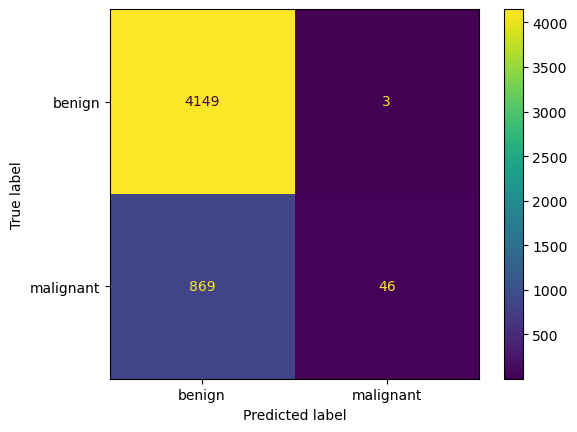

              precision    recall  f1-score   support

           0       0.83      1.00      0.90      4152
           1       0.94      0.05      0.10       915

    accuracy                           0.83      5067
   macro avg       0.88      0.52      0.50      5067
weighted avg       0.85      0.83      0.76      5067



In [ ]:
get_cm_cr(vgg_random_forest, features_flat_test_pca_50, target_flat_test)

This is really the opposite of balancing. I hope I will one day find out how and why weight balancing options in tree-based models alywas make my models even more unbalanced :)

# 4. Neural Networks
I will use the Tensorflow environment because it appears to be begineer-friendly, yet very powerful.
Starting from simple models, we will will gradually move forward towards more hyperparameter tuning, more complex NN structures etc.

The first model is an ordinary CNN tuned for binary classification.

### Classic Tensorflow CNN

In [ ]:
input_shape = skin_images.shape[1:]
skin_cancer_model = Sequential([
    Input(input_shape),

    Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    MaxPool2D(2,2),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(2,2),
    Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    MaxPool2D(2,2),

    Dropout(0.25),
    Flatten(),

    Dense(64, activation='relu'),

    Dense(1, activation='sigmoid')
    ])

In [ ]:
skin_cancer_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Recall', 'Precision'])

In [ ]:
#skin_cancer_model_history = skin_cancer_model.fit(features_train, target_train, validation_data=(features_test, target_test),
#                                                  batch_size=128, epochs=30)

In [ ]:
skin_cancer_model = load_model('skin_cancer_model')
skin_cancer_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)      

159/159 [==============================] - 23s 145ms/step


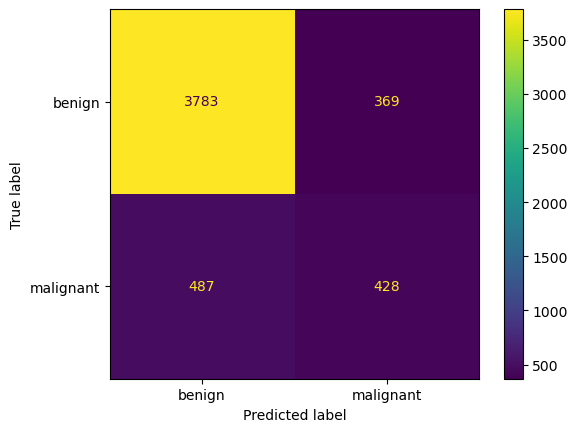

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      4152
           1       0.54      0.47      0.50       915

    accuracy                           0.83      5067
   macro avg       0.71      0.69      0.70      5067
weighted avg       0.82      0.83      0.83      5067



In [ ]:
get_cm_cr(skin_cancer_model, features_test, target_test)

Well, I didnt really expect that the results would be that low, but at least **Recall** and **Precision** are quite balanced. Let's try Transfer Learning once again.

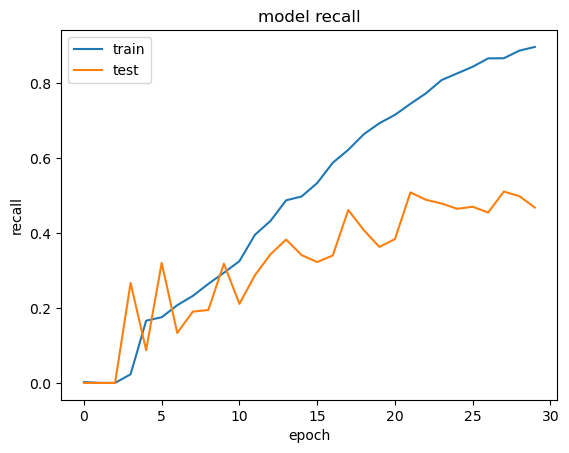

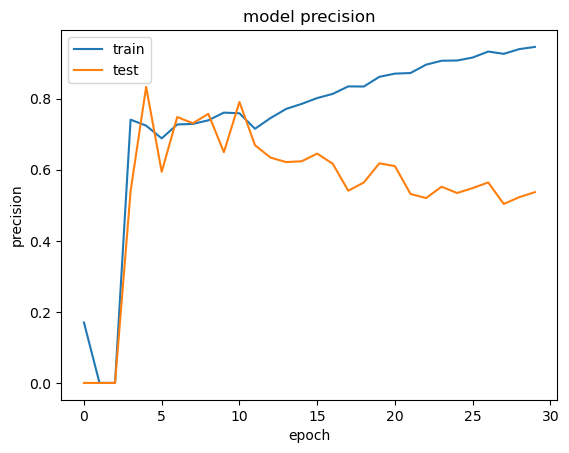

In [ ]:
skin_cancer_model_history = load_model_history('skin_cancer_model_history.pickle')
for metric_str in ['recall', 'precision']:
    plot_model_history(skin_cancer_model_history, metric_str)

**Recall** is moving really shaky and doesn't really go that far, but at least it goes in the right direction. **Precision**, though, is decreasing constantly right after the 9th epoch... Obviously, this model is pretty weak. No custom Convolutional Neural Network work out well for the purpose of this paper - the current one is just one of many failed experiments. So lets move on to that Transfer Learning feature vector once again.

### CNN with Transfer Learning
I will use the same feature extractor that worked rather well for that custom CNN-SVM experiment presented at the end of the Support Vector Machines section.

In [ ]:
skin_transfer_learning = Sequential([
    feature_extractor_layer,
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [ ]:
skin_transfer_learning.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Recall', 'Precision'])

In [ ]:
#skin_transfer_learning_history = skin_transfer_learning.fit(features_train, target_train,
#                                validation_data=(features_test, target_test), batch_size=128, epochs=20)

In [ ]:
skin_transfer_learning_sigmoid = load_model('skin_transfer_learning_sigmoid')
skin_transfer_learning_sigmoid.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_2 (Dense)             (None, 64)                81984     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2340033 (8.93 MB)
Trainable params: 82049 (320.50 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


159/159 [==============================] - 46s 283ms/step


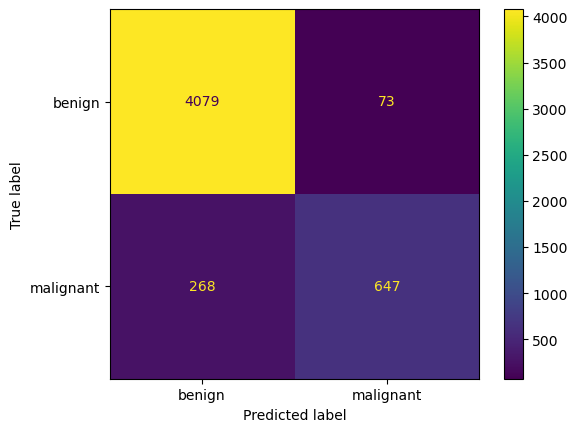

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      4152
           1       0.90      0.71      0.79       915

    accuracy                           0.93      5067
   macro avg       0.92      0.84      0.88      5067
weighted avg       0.93      0.93      0.93      5067



In [ ]:
get_cm_cr(skin_transfer_learning_sigmoid, features_test, target_test)

Much better. **Recall** on the positives hasn't gone that far up yet. It even surpasses the 70% requirement set in the beginning. **Precision** on the positives, on the other hand, exploded.

Fair enough, this model is the best so far and can be considered as a success. There is one thing bothering me here - the No1 most important metric here is the lowest of all the metrics, by a considerable distance. Surely, there must be a way to optimise further, without breaking the other key metrics.

Let's not bypass the fact that 93% is the best overall **Accuracy** achievement for our models so far.

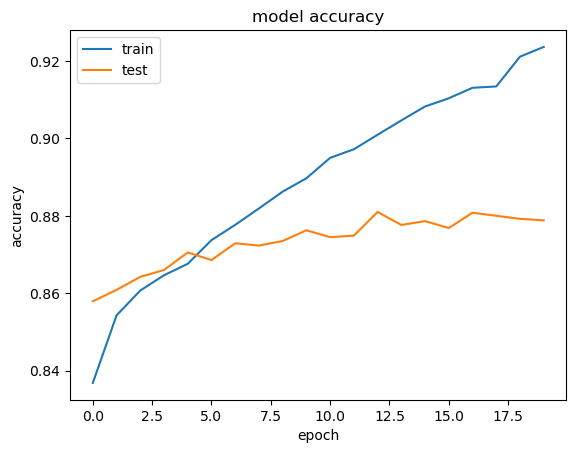

In [ ]:
skin_transfer_learning_history = load_model_history('skin_transfer_learning_history.pickle')
plot_model_history(skin_transfer_learning_history, 'accuracy')

### Transfer Learning CNN with Balance <a id='256'></a>

There are more ways to improve the balance of power between the heavyweight and lightweight categories. First, I will set the initial bias to the logarithm of the division of sum of the positives by the sum of the negatives.

In [ ]:
initial_bias = np.log([skin_cancer.target.value_counts().values[1] / skin_cancer.target.value_counts().values[0]])
print(initial_bias)

[-1.52643121]


Next, I will use the class_weight functionality form scikit-learn to try and come up with an object that would resemble *class_weight='balanced'* impact that helped us reach better results with the SVM models. We actually used the same object for the SVM-CNN-combo.

In [ ]:
balanced_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                        classes= np.unique(target_train), y= target_train)
balanced_weights = dict(enumerate(balanced_weights))
print(balanced_weights)

{0: 0.6082727982229693, 1: 2.808982533961741}


The only thing we've got left is to build and train the model.

In [ ]:
skin_cancer_tl_weights = Sequential([
    feature_extractor_layer,
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid', bias_initializer=tf.keras.initializers.Constant(initial_bias))
    ])

In [ ]:
skin_cancer_tl_weights.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Recall'])

In [ ]:
#skin_cancer_tl_weights_history = skin_cancer_tl_weights.fit(features_train,
#                                    target_train, validation_data=(features_test, target_test),
#                                    batch_size=128, epochs=20, class_weight=balanced_weights)

In [ ]:
skin_cancer_tl_weights = load_model('skin_cancer_tl_weights')
skin_cancer_tl_weights.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_4 (Dense)             (None, 64)                81984     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2340033 (8.93 MB)
Trainable params: 82049 (320.50 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


159/159 [==============================] - 45s 277ms/step


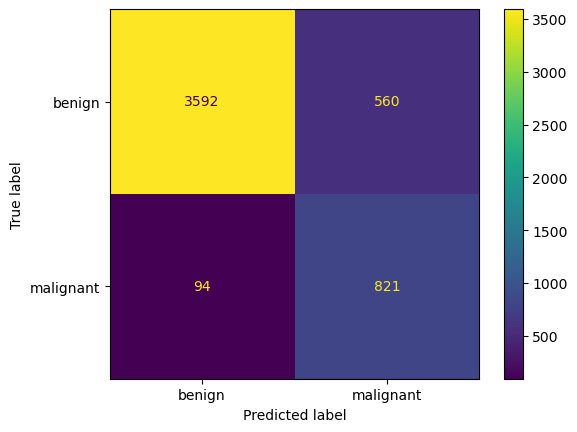

              precision    recall  f1-score   support

           0       0.97      0.87      0.92      4152
           1       0.59      0.90      0.72       915

    accuracy                           0.87      5067
   macro avg       0.78      0.88      0.82      5067
weighted avg       0.91      0.87      0.88      5067



In [ ]:
get_cm_cr(skin_cancer_tl_weights, features_test, target_test)

Finally, it looks like we have a really good model! The weight-balancing "magic" did pay off after all. **Recall** of 90% on the positives, without breaking the respective **Precision**, is an impressive result, especially considering the imballanced dataset! Being able to tell correctly melanoma from other skin developments in 90% of the cases, based only on images, is not exactly an unremarkable achievement.

# 5. Mixed Models: Image + Tabular

We already tried many different things. The only thing that's left to try is and combine the Image data and the tabular data. The idea is to check if the tabular data contains any info further that might help our models get the classification right. Let's see how that goes.

### Prepare the features and the target
This time, in order to prepare the data, we will have to do a little more than just a regular train_test_split.

To split and randomly shuffle the image data and tabular data but keep their integrity, we need to connect the target with the tabular features for modelling, as the mechanics of the train_test_split do not allow the use of more than 2 input variables.

In [ ]:
target_mixed = np.array(skin_cancer.target).reshape(len(skin_cancer.target), 1)
features_mixed_model = np.append(features_for_modelling, target_mixed, axis=1)

In [ ]:
assert_equal(features_mixed_model.shape[1], 19)

After the target is once again merged with the tabular features for modelling, we can effectively split our tabular data, and our image data into train and test splits. Immediately after, the train and test target is dissacociated from the tabular features once again.

In [ ]:
train_data_X, test_data_X, train_img_X, test_img_X = train_test_split(features_mixed_model, skin_images,
                                                                      test_size=0.2, random_state=42)
train_data_Y = np.array([train_data_X[i][features_mixed_model.shape[1] - 1] for i in range(len(train_data_X))])
test_data_Y = np.array([test_data_X[i][features_mixed_model.shape[1] - 1] for i in range(len(test_data_X))])

In [ ]:
assert_equal(len(train_data_Y), len(train_data_X))
assert_equal(len(train_data_Y), len(train_img_X))
assert_equal(len(test_data_Y), len(test_data_X))
assert_equal(len(test_data_Y), len(test_img_X))

In [ ]:
train_data_X = np.delete(train_data_X, features_mixed_model.shape[1] - 1, axis=1)
test_data_X = np.delete(test_data_X, features_mixed_model.shape[1] - 1, axis=1)

Finally, we have to set the input parameters for the two "sub-models" which will merge into one further down the line. These parameters are the same for all models:

In [ ]:
meta_model_input = train_data_X.shape[1]
input_shape = skin_images.shape[1:]

### CNN with Transfer Learning + Tabular Data
We will start with using an approach that has already worked for us - the same old feature vector taken from MobileNet via TransferHub. We won't put the bottle-neck Dense layer just yet, instead we will keep the nodes from the layer after the feature extractor as an output of this model.
Then, we will build the model containing tabular metadata where we will keep many output neurons.
In the end, we will concatenate the outputs of the two sub-models into one, and take it from there.
The output of the whole model after the merge of the two models will have similar hyperparameters as the ones before it.

In [ ]:
image_model = Sequential([
    feature_extractor_layer,
    Dense(64, activation= 'relu', name="image_dense"),
    Dropout(0.25)
    ])

In [ ]:
meta_model = Sequential([
    Input(shape=meta_model_input, name="meta_input"),
    Dense(64, activation='relu', name="meta_dense"),
    Dropout(0.25)
    ])

In [ ]:
x = tf.keras.layers.concatenate([image_model.output, meta_model.output], name="concat_image_meta")

x = Dense(8, activation='relu')(x)
predictions = Dense(1, activation='sigmoid', bias_initializer=tf.keras.initializers.Constant(initial_bias))(x)
model_mix_balanced = Model(inputs = [image_model.input, meta_model.input], outputs = predictions)

model_mix_balanced.compile(optimizer= "adam", loss='binary_crossentropy', metrics=['accuracy', 'Recall', 'Precision'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 6, verbose=1, mode='min', restore_best_weights= True)
checkpoint = ModelCheckpoint('model_mix_balanced.weights.hdf5', monitor='val_recall', verbose=1, save_best_only=True, mode='max')

callbacks= [early_stopping, checkpoint]

In [ ]:
#model_mix_balanced_history = model_mix_balanced.fit(x=[train_img_X, train_data_X], y=train_data_Y,
#          validation_data=([test_img_X, test_data_X], test_data_Y),
#         callbacks=callbacks, epochs=50, batch_size=128)

In [ ]:
model_mix_balanced = load_model('model_mix_balanced')
model_mix_balanced.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 keras_layer_input (InputLa  [(None, 128, 128, 3)]        0         []                            
 yer)                                                                                             
                                                                                                  
 keras_layer (KerasLayer)    (None, 1280)                 2257984   ['keras_layer_input[0][0]']   
                                                                                                  
 meta_input (InputLayer)     [(None, 18)]                 0         []                            
                                                                                                  
 image_dense (Dense)         (None, 64)                   81984     ['keras_layer[0][0]']   

159/159 [==============================] - 63s 390ms/step


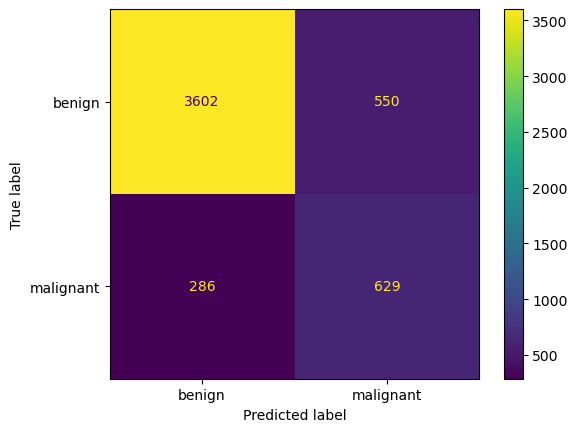

              precision    recall  f1-score   support

           0       0.93      0.87      0.90      4152
           1       0.53      0.69      0.60       915

    accuracy                           0.84      5067
   macro avg       0.73      0.78      0.75      5067
weighted avg       0.86      0.84      0.84      5067



In [ ]:
get_cm_cr(model_mix_balanced, [test_img_X, test_data_X], test_data_Y)

This model is by no means spectacular, but it almost does the job. It has a pretty good **Recall** regarding the melanoma cases, and this doesn't come at the expense of **Precision**. By our criteria, the model is almost there and one of the rather successful ones.

In [ ]:
model_mix_balanced_history_loaded = load_model_history('model_mix_balanced_history.pickle')

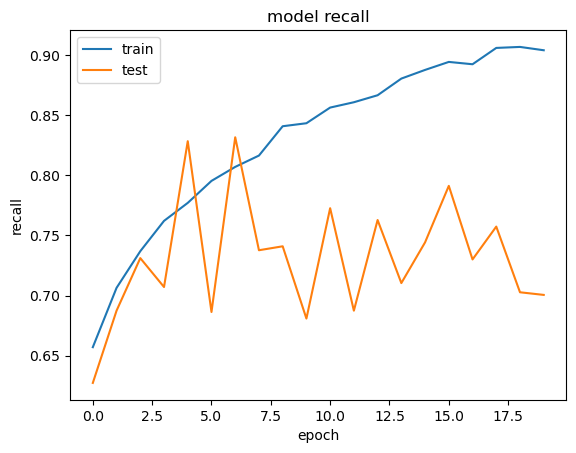

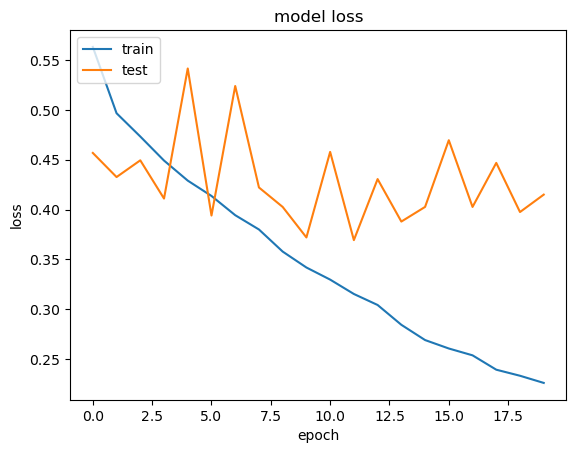

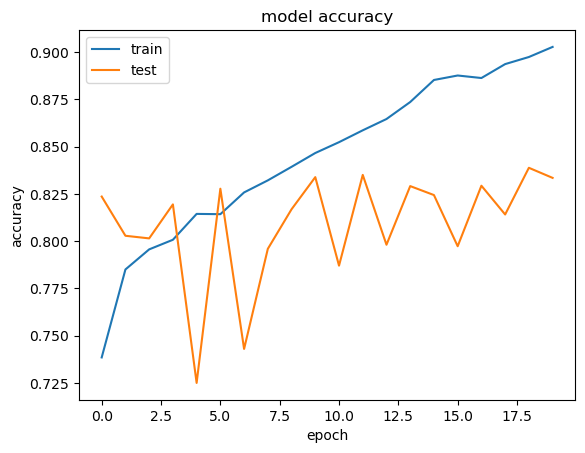

In [ ]:
for metric_str in ['recall', 'loss', 'accuracy']:
    plot_model_history(model_mix_balanced_history_loaded, metric_str)

Like most other curves representing our models' learning struggles, there are dramatic fluctuations in the beginning, which gradually become tame as the epochs go by.

### ResNet-50 Transfer Learning + Tabular Data
The last experiment I would like to present also has a lot to do with Transfer Learning.

With this model, the procedure from the last model was pretty much reinforced, only this time I had to freeze ResNet-50's layers so that they don't train according to the data but only excercise their expertize on it. Besides, using the whole ResNet-50 would have taken ages :)

However, this current model developed in a way that by no means could be called fast either. The results were not very bad, but clearly below the expectations.

In [ ]:
resnet_50 = tf.keras.applications.resnet50.ResNet50(weights= 'imagenet', include_top=False, input_shape=input_shape)
for layer in resnet_50.layers:
    layer.trainable = False
image_model_resnet = Sequential([
    resnet_50,
    GlobalAveragePooling2D(),
    Dense(48, activation='softmax')
    ])

In [ ]:
meta_model_resnet = Sequential([
    Input(shape=meta_model_input, name="meta_input"),
    Dense(48, activation='relu', name="meta_dense2"),
    Dropout(0.2)
    ])

In [ ]:
x = tf.keras.layers.concatenate([image_model_resnet.output, meta_model_resnet.output], name="concat_image_meta")

x = Dense(8, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model_cnn_resnet = Model(inputs = [image_model_resnet.input, meta_model_resnet.input], outputs = predictions)

model_cnn_resnet.compile(optimizer= "adam", loss='binary_crossentropy', metrics=['accuracy', 'Recall', 'Precision'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 6, verbose=1, mode='min', restore_best_weights= False)
checkpoint = ModelCheckpoint('model_cnn_resnet.weights.hdf5', monitor='val_recall', verbose=1, save_best_only=True, mode='max')

callbacks= [early_stopping, checkpoint]

In [ ]:
#model_cnn_resnet_history = model_cnn_resnet.fit(x=[train_img_X, train_data_X], y=train_data_Y,
#          validation_data=([test_img_X, test_data_X], test_data_Y),
#            class_weight=balanced_weights, callbacks=callbacks, epochs=60, batch_size=128)

In [ ]:
model_cnn_resnet = load_model('model_cnn_resnet')
model_cnn_resnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 resnet50_input (InputLayer  [(None, 128, 128, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 resnet50 (Functional)       (None, 4, 4, 2048)           2358771   ['resnet50_input[0][0]']      
                                                          2                                       
                                                                                                  
 meta_input (InputLayer)     [(None, 18)]                 0         []                            
                                                                                            

Unfortunately, none of the key metrics meets the expectations. Otherwise, not too bad. This model is well-known as a very powerful CNN, and probably it takes more time and lower learning rates to get it to work properly.

# Conclusion

In the course of writing this paper, I saw and tried many ways and tried many possible scenarios to improve melanoma diagnostics.

Out of the two models that met the criteria set in the beginning of this paper, there is one clear contender for paper's best-performing model - that is the [Transfer Learning CNN with Balance model](#256).

The main reason why is it has the highest score for **Recall**, which means it has the best capacity to tell when someone does and when someone doesn't suffer from melanoma. That is the most important info for any potential cancer patient. Furthermore, the Transfer Learning with Balance model does so managing to keep the other important metrics in tact.

# Sources:

https://www.tensorflow.org/tutorials/keras/classification

https://www.tensorflow.org/tutorials/load_data/images

https://towardsdatascience.com/multi-label-image-classification-in-tensorflow-2-0-7d4cf8a4bc72

https://towardsdatascience.com/leveraging-the-power-of-jupyter-notebooks-26b4b8d7c622?gi=f0c152b1fd25#:~:text=IOPub%20data%20rate%3A&text=IOPub%20data%20rate%20exceeded.,%60%2D%2DNotebookApp.

https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438

https://machinelearningmastery.com/weighted-average-ensemble-for-deep-learning-neural-networks/

https://towardsdatascience.com/dont-overfit-how-to-prevent-overfitting-in-your-deep-learning-models-63274e552323?gi=d63bc9df1d93

https://blog.paperspace.com/ensembling-neural-network-models/

https://rmoklesur.medium.com/what-you-need-to-know-about-sparse-categorical-cross-entropy-9f07497e3a6f

https://medium.com/intelligentmachines/convolutional-neural-network-and-regularization-techniques-with-tensorflow-and-keras-5a09e6e65dc7

https://blog.paperspace.com/ensembling-neural-network-models/
https://www.mdpi.com/

https://towardsdatascience.com/neural-networks-with-multiple-data-sources

https://opt-ml.org/papers/2021/paper53.pdf

https://machinelearningmastery.com/cross-validation-for-imbalanced-classification/

https://www.kaggle.com/datasets/cdeotte/jpeg-isic2019-512x512/code

https://datascience.stackexchange.com/questions/92658/how-to-plot-the-bar-charts-of-precision-recall-and-f-measure

https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/